In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [48]:
#Load Datasets

## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

#load geospatial data
tracts_geodata = gpd.read_file("tracts.geojson")
tracts_geodata = tracts_geodata.set_index("GEOID")
tracts_geodata.index = tracts_geodata.index.astype(int)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_51087/1928580862.py:4: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


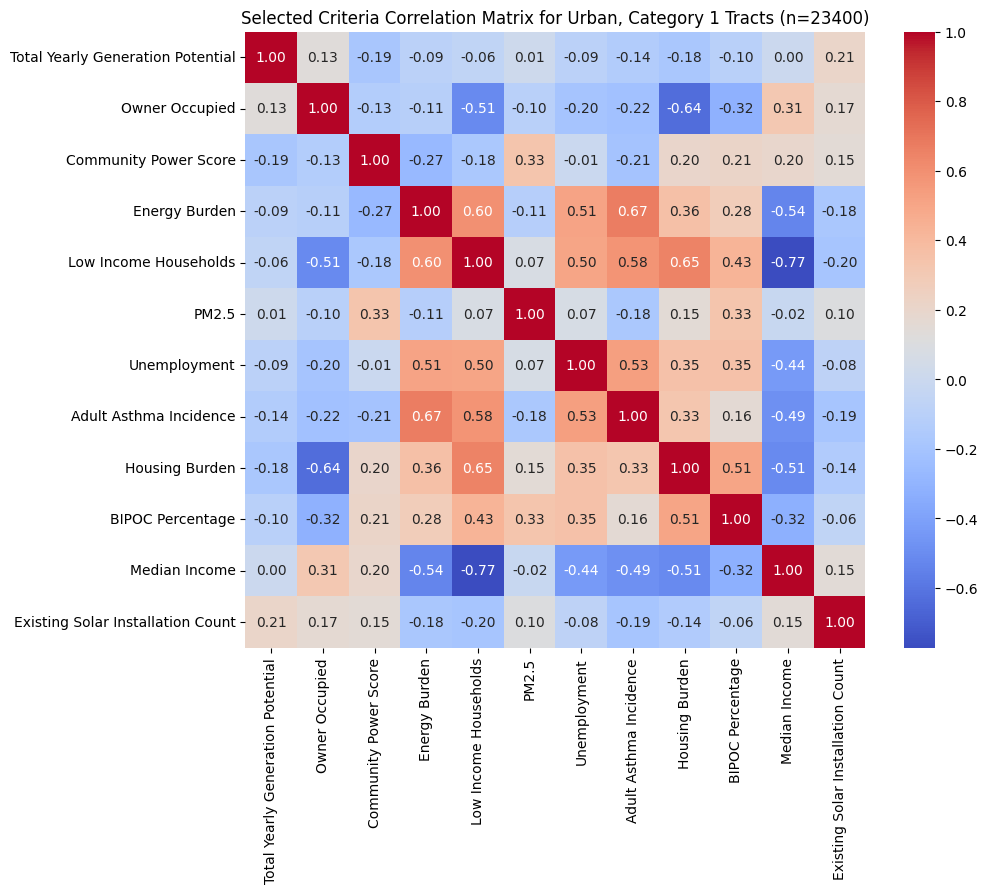

In [51]:
#Correlation Matrix
criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score', 
             'energy_burden', 'Percent of individuals below 200% Federal Poverty Line',
             'PM2.5 in the air', 'Unemployment (percent)', 
             'Current asthma among adults aged greater than or equal to 18 years']

comparison_criteria = ['Housing burden (percent)', "bipoc_percent", "median_income", "existing_installs_count"]

correlation_matrix = cleaned_data[criteria + comparison_criteria].corr()
labels = ['Total Yearly Generation Potential', 'Owner Occupied', 'Community Power Score', 
             'Energy Burden', 'Low Income Households','PM2.5', 'Unemployment', 
             'Adult Asthma Incidence', 
             'Housing Burden', "BIPOC Percentage", "Median Income", "Existing Solar Installation Count"]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=labels, yticklabels=labels )
plt.title("Selected Criteria Correlation Matrix for Urban, Category 1 Tracts (n=23400)")
plt.show()

In [123]:
#Normalize Data

criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score']

# criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score', 
#              'Energy burden (percentile)', 'Percent of individuals below 200% Federal Poverty Line (percentile)',
#              'PM2.5 in the air (percentile)', 'Unemployment (percent)']

normalized_data = cleaned_data.copy()

#minmax normalization
for criterion in criteria:
    normalized_data[criterion] = normalized_data[criterion] / (normalized_data[criterion].max() - normalized_data[criterion].min())


In [149]:
#MCDA for Feasibility, Impact, Co-Benefits

weights_feasibility = {
    'yearly_sunlight_kwh_total': 0.4,
    'owner_occupied': 0.35,
    'community_power_score': 0.25,
}

weights_impact = {
    'Energy burden (percentile)': 0.4,
    'Percent of individuals below 200% Federal Poverty Line (percentile)': 0.2,
    'Unemployment (percent) (percentile)': 0.2,
    'PM2.5 in the air (percentile)': 0.2
}

mcda_output = pd.DataFrame()

# Perform the weighted sum calculation
mcda_output['feasibility_score'] = (normalized_data[list(weights_feasibility.keys())] * list(weights_feasibility.values())).sum(axis=1)
mcda_output['impact_score'] = (normalized_data[list(weights_impact.keys())]/100 * list(weights_impact.values())).sum(axis=1)
mcda_output['total_score'] = mcda_output['feasibility_score'] + mcda_output['impact_score']

# Categorize the scores
# bins = [0, 0.33, 0.67, 1]
labels = ['low', 'med', 'high']
mcda_output['feasibility_potential'] = pd.cut(mcda_output['feasibility_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['impact_potential'] = pd.cut(mcda_output['impact_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['total_potential'] = pd.cut(mcda_output['total_score'], bins=3, labels=labels, include_lowest=True)

##Q: How does the binning work? Important to understand the results
print(mcda_output.head)

<bound method NDFrame.head of              feasibility_score  impact_score  total_score   
GEOID                                                       
53067010600           0.310231         0.430     0.740231  \
53067011500           0.345077         0.452     0.797077   
53067011300           0.257457         0.402     0.659457   
53067011200           0.223722         0.400     0.623722   
53067010920           0.334236         0.412     0.746236   
...                        ...           ...          ...   
6071007408            0.382718         0.742     1.124718   
6071007409            0.525513         0.620     1.145513   
6071007410            0.387099         0.614     1.001099   
6071007303            0.303377         0.694     0.997377   
6071003404            0.370126         0.674     1.044126   

            feasibility_potential impact_potential total_potential  
GEOID                                                               
53067010600                   med     

In [150]:
#print
print(mcda_output['feasibility_potential'].value_counts())
print(mcda_output['impact_potential'].value_counts())

feasibility_potential
med     16415
low      3809
high     3176
Name: count, dtype: int64
impact_potential
med     12602
high     7618
low      3180
Name: count, dtype: int64


In [152]:
#Look at Top 10 tracts for feasibility, impact, cobenefits, total

#Merge larger dataset for more information on tracts
merged_mcda_output = cleaned_data.merge(mcda_output, left_index=True, right_index=True)[["state_abbr", "county_name", "feasibility_score", "impact_score", "total_score"]]

print("Top 10 Tracts for Feasibility:")
print(merged_mcda_output.nlargest(10, 'feasibility_score')[["state_abbr", "county_name", "feasibility_score"]])

print("Top 10 Tracts for Impact:")
print(merged_mcda_output.nlargest(10, 'impact_score')[["state_abbr", "county_name", "impact_score"]])

print("Top 10 Tracts Overall")
print(merged_mcda_output.nlargest(10, 'total_score')[["state_abbr", "county_name", "feasibility_score", "impact_score", "total_score"]])

#Map these next to cities


Top 10 Tracts for Feasibility:
            state_abbr         county_name  feasibility_score
GEOID                                                        
6059021813          CA       Orange County           0.667503
17043840101         IL       DuPage County           0.664502
6081602300          CA    San Mateo County           0.642399
6059099510          CA       Orange County           0.628656
6037502700          CA  Los Angeles County           0.627544
6077005119          CA  San Joaquin County           0.622630
25025981300         MA      Suffolk County           0.621683
6059099509          CA       Orange County           0.619465
6065044919          CA    Riverside County           0.615460
6001438203          CA      Alameda County           0.613512
Top 10 Tracts for Impact:
            state_abbr         county_name  impact_score
GEOID                                                   
6029001500          CA         Kern County         0.978
40143008001         OK      

In [127]:
#Top scores by state
# Group the data by states and calculate the sum of feasibility scores
state_feasibility = merged_mcda_output.groupby('state_abbr')['feasibility_score']

# Get the top 10 states with the highest median feasibility scores
print(state_feasibility.median().nlargest(10))

# Group the data by states and calculate the sum of impact scores
state_impact = merged_mcda_output.groupby('state_abbr')['impact_score']

# Get the top 10 states with the highest median impact scores
print(state_impact.median().nlargest(10))

# Group the data by states and calculate the total scores
state_total = merged_mcda_output.groupby('state_abbr')['total_score']

# Get the top 10 states with the highest median impact scores
print(state_total.median().nlargest(10))

state_abbr
IL    0.425157
CA    0.418875
MA    0.411802
NM    0.408865
DE    0.389509
MD    0.384558
CO    0.378531
RI    0.377081
VA    0.371261
NY    0.367710
Name: feasibility_score, dtype: float64
state_abbr
MS    0.790
AL    0.785
LA    0.770
MI    0.722
IN    0.716
GA    0.716
OH    0.714
OK    0.692
AR    0.684
KY    0.674
Name: impact_score, dtype: float64
state_abbr
IL    1.095227
OH    1.037711
MI    1.026117
MS    1.004121
AL    1.003332
PA    0.982347
NY    0.980136
CT    0.978244
AR    0.975842
CA    0.971684
Name: total_score, dtype: float64


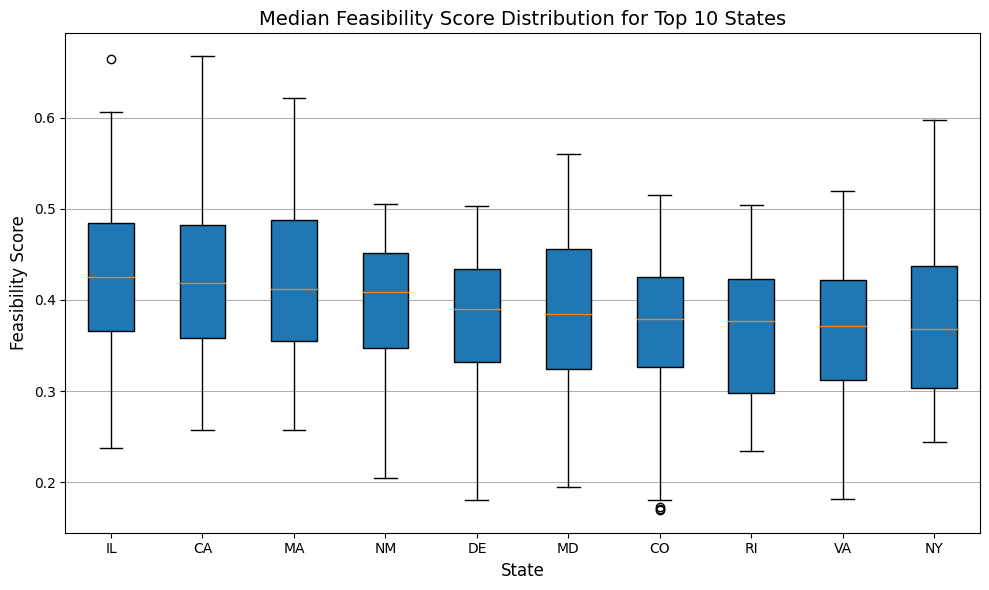

In [134]:
# Map state by state feasibility score data
states_to_compare = ['IL', 'CA', 'MA', 'NM', 'DE', 'MD', 'CO', 'RI', 'VA', 'NY']

# Filter the data for the selected states
data_to_plot = [merged_mcda_output[merged_mcda_output['state_abbr'] == state]['feasibility_score'] for state in states_to_compare]

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom box plot colors
# box_plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the box plot for each state with custom colors
box_plot = ax.boxplot(data_to_plot, labels=states_to_compare, patch_artist=True)

# # Set individual colors for each box
# for patch, color in zip(box_plot['boxes'], box_plot_colors):
#     patch.set_facecolor(color)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('State', fontsize=12)
plt.ylabel('Feasibility Score', fontsize=12)
plt.title('Median Feasibility Score Distribution for Top 10 States', fontsize=14)

# Customize font size for tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()





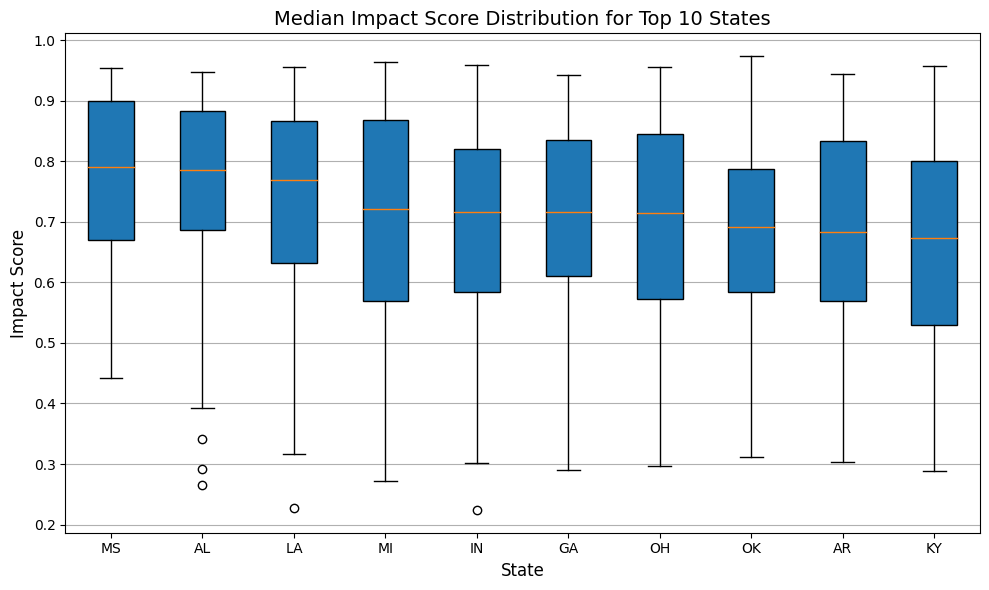

In [139]:
# Map state by state feasibility score data
states_to_compare = ['MS', 'AL', 'LA', 'MI', 'IN', 'GA', 'OH', 'OK', 'AR', 'KY']

# Filter the data for the selected states
data_to_plot = [merged_mcda_output[merged_mcda_output['state_abbr'] == state]['impact_score'] for state in states_to_compare]

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom box plot colors
# box_plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the box plot for each state with custom colors
box_plot = ax.boxplot(data_to_plot, labels=states_to_compare, patch_artist=True)

# # Set individual colors for each box
# for patch, color in zip(box_plot['boxes'], box_plot_colors):
#     patch.set_facecolor(color)
patch.set_facecolor('#1f77b4')
# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('State', fontsize=12)
plt.ylabel('Impact Score', fontsize=12)
plt.title('Median Impact Score Distribution for Top 10 States', fontsize=14)

# Customize font size for tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()





In [154]:
#Merge geometry attributes with mcda output
mcda_output['feasibility_potential'] = mcda_output['feasibility_potential'].astype(str)
mcda_output['impact_potential'] = mcda_output['impact_potential'].astype(str)
mcda_output['total_potential'] = mcda_output['total_potential'].astype(str)
mcda_geodata = tracts_geodata.merge(mcda_output, left_index=True, right_index=True)

#Print geometry data to file
mcda_geodata.to_file("mcda_tracts.geojson", driver='GeoJSON')

KeyboardInterrupt: 

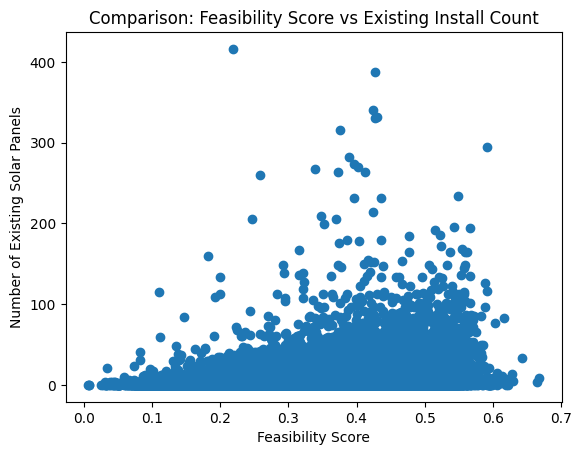

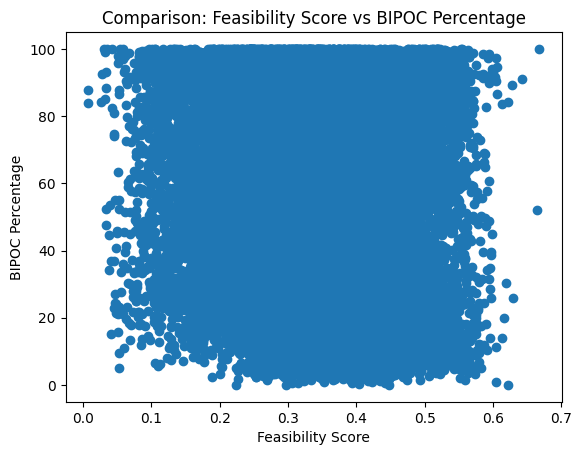

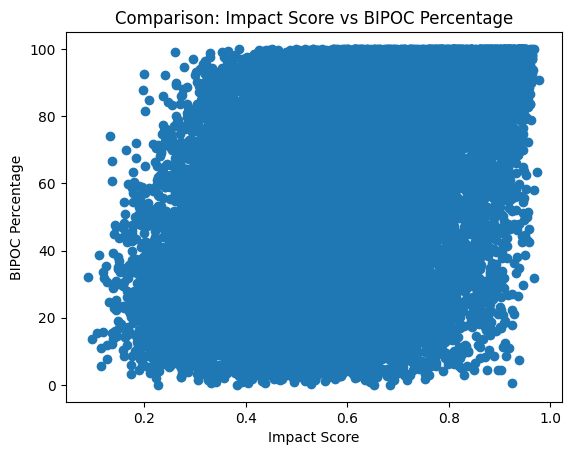

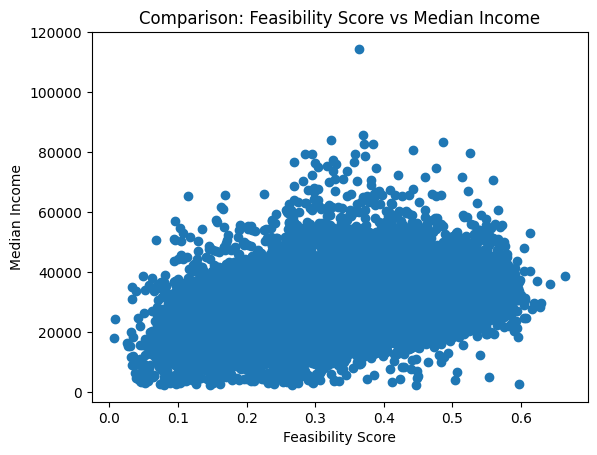

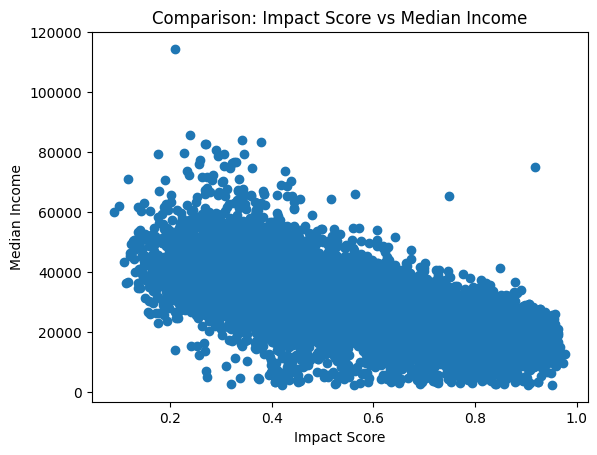

In [122]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)

# Scatter plot of 'feasibility_score' vs 'existing_install_count'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['existing_installs_count'])
plt.xlabel('Feasibility Score')
plt.ylabel('Number of Existing Solar Panels')
plt.title('Comparison: Feasibility Score vs Existing Install Count')
plt.show()

# Scatter plot of 'feasibility_score' vs 'bipoc_percent'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['bipoc_percent'])
plt.xlabel('Feasibility Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Feasibility Score vs BIPOC Percentage')
plt.show()

plt.scatter(mcda_output['impact_score'], cleaned_data['bipoc_percent'])
plt.xlabel('Impact Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Impact Score vs BIPOC Percentage')
plt.show()

# Scatter plot of 'feasibility_score' vs 'median_income'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['median_income'])
plt.xlabel('Feasibility Score')
plt.ylabel('Median Income')
plt.title('Comparison: Feasibility Score vs Median Income')
plt.show()

plt.scatter(mcda_output['impact_score'], cleaned_data['median_income'])
plt.xlabel('Impact Score')
plt.ylabel('Median Income')
plt.title('Comparison: Impact Score vs Median Income')
plt.show()

